In [ ]:
!pip install transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.9/7.9 MB 39.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 311.2/311.2 kB 32.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.8/3.8 MB 80.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 72.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 295.0/295.0 kB 29.5 MB/s eta 0:00:00


In [ ]:
!pip install accelerate

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 261.4/261.4 kB 1.9 MB/s eta 0:00:00


In [ ]:
import numpy as np
import pandas as pd
import os

%matplotlib inline
from matplotlib import rc
import matplotlib.pyplot as plt
import seaborn as sns

plt.rcParams['figure.figsize'] = [7, 7]

import transformers
import accelerate
from transformers import BertModel, BertPreTrainedModel, AutoTokenizer, AutoConfig, BertForSequenceClassification, BertTokenizer,\
PreTrainedTokenizerFast, AdamW, get_linear_schedule_with_warmup, Trainer, TrainingArguments

from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import precision_recall_fscore_support, accuracy_score,mean_absolute_error, \
median_absolute_error, mean_squared_error, mean_absolute_percentage_error, r2_score, f1_score, \
ConfusionMatrixDisplay, confusion_matrix

import nltk
from nltk.corpus import stopwords

import warnings
warnings.filterwarnings('ignore')

import torch
import torch.nn as nn
from torch.nn import CrossEntropyLoss
import torch.optim as optim
from torchtext.vocab import FastText, vocab
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
from torch.nn.utils.clip_grad import clip_grad_norm
from torch.utils.data import TensorDataset, DataLoader

from tqdm import tqdm, trange

# Reading data

First, let's have a look at the dataset

In [ ]:
df = pd.read_csv('https://raw.githubusercontent.com/denisyurievichpisarenko/nplus1/main/db.txt',
                 sep='~~', engine='python')
df.shape

(10107, 7)

In [ ]:
df.sample(n=10)

,time,date,difficulty,topic,heading,author,text
2512,16:31,14.10.20,3.1,оружие,российские воздушные командные пункты переведу...,василий сычев,перспективный российский воздушный командный ...
3216,14:41,18.01.21,3.1,оружие,армия сша обзаведется дронами для доставки бое...,василий сычев,армия сша обнародовала запрос на информацию о...
2609,12:32,23.10.20,3.1,оружие,бразильцы приступили к сборке первого реактора...,василий сычев,бразильский экспериментальный центр арамар в ...
2118,16:52,02.09.20,3.1,оружие,американские военные провели первые испытания ...,василий сычев,агентство перспективных оборонных разработок ...
2307,15:29,21.09.20,2.3,зоология,потеря матери снизила репродуктивный успех сам...,сергей коленов,самцы шимпанзе которые лишились матери в пери...
4942,12:19,27.07.21,1.2,медицина,в россии начались клинические испытания комбин...,анастасия кузнецова–фантони,началась i-ii фаза клинических испытаний совм...
5970,10:45,18.11.21,2.9,археология,римскую виллу в хорватии перестроили для защит...,михаил подрезов,археологи обнаружили на хорватском острове ра...
1010,20:23,08.05.20,4.1,астрономия,астероид рюгу «загорел» под солнечными лучами,александр войтюк,благодаря данным со станции «хаябуса-2» астро...
5574,15:59,06.10.21,3.4,астрономия,астрономы открыли новую комету главного пояса,александр войтюк,данные наблюдений наземных телескопов помогли...
5634,18:46,13.10.21,2.1,космонавтика,китайцы посадили ракету после взлета на 100 ме...,григорий копиев,китайская частная компания deep blue aerospac...


In [ ]:
df.isna().sum()

time            0
date            0
difficulty      0
topic           4
heading         0
author        120
text          241
dtype: int64

Some values in the text column are empty. Compared to the whole size of the dataset, it is not a great number, so we can easily drop them.

In [ ]:
df = df.dropna()
df.shape

(9755, 7)

Finally, let's delete those texts which have inappropriately small (this probably signals that they were not read accurately by the scrapper).

In [ ]:
df['length_of_text'] = df['text'].apply(lambda x: len(str(x).split(' ')))
df.head()

,time,date,difficulty,topic,heading,author,text,length_of_text
0,23:00,01.01.20,1.8,медицина,генную терапию против гемофилии а назвали безо...,полина лосева,врачи опубликовали результаты обследования па...,753
1,16:18,03.01.20,3.1,оружие,вмс сша разработают концепцию применения больш...,василий сычев,вмс сша в ближайшее время сформируют рабочую ...,179
2,14:21,03.01.20,3.1,оружие,американцы разработали геозонирование для зени...,василий сычев,центральное разведывательное управление сша р...,224
3,12:22,03.01.20,3.1,оружие,умер конструктор одной из самых массовых боевы...,василий сычев,1 января 2020 года в возрасте 86 лет умер але...,237
4,09:56,03.01.20,3.1,оружие,австралийцы вооружатся беспилотными ведомыми в...,василий сычев,министерство обороны австралии планирует пост...,283


In [ ]:
df['length_of_text'].describe()

count    9755.000000
mean      421.875961
std       214.141729
min         2.000000
25%       261.000000
50%       411.000000
75%       561.500000
max      1431.000000
Name: length_of_text, dtype: float64

In [ ]:
df = df[df['length_of_text'] > 20]
df.shape

(9439, 8)

# EDA

The number of articles for each topic. Medicine and zoology are the most common ones.

In [ ]:
grp = df.groupby('topic', as_index=False).agg({'time':'count'}).sort_values(by='time', ascending=False).rename(columns={'time':'articles'})
grp.head()

,topic,articles
10,зоология,1076
18,медицина,1050
4,археология,954
5,астрономия,884
21,оружие,766


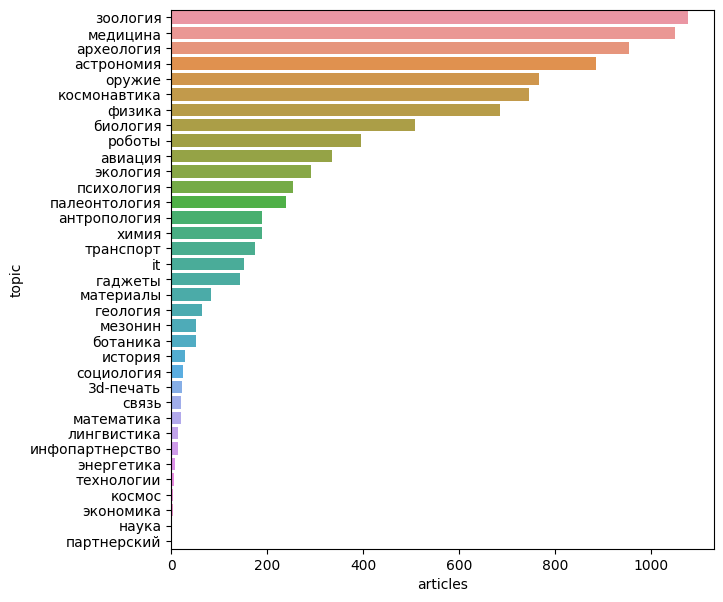

In [ ]:
sns.barplot(data=grp, x='articles', y='topic')
plt.show()

The difficulty per topic is as follows. For the majority of the topics, the median difficulty is between 2 and 4. The exceptions include physics, materials, and chemistry with a greater median difficulty. With a median difficulty about 6, physics is the most difficult topic among all.

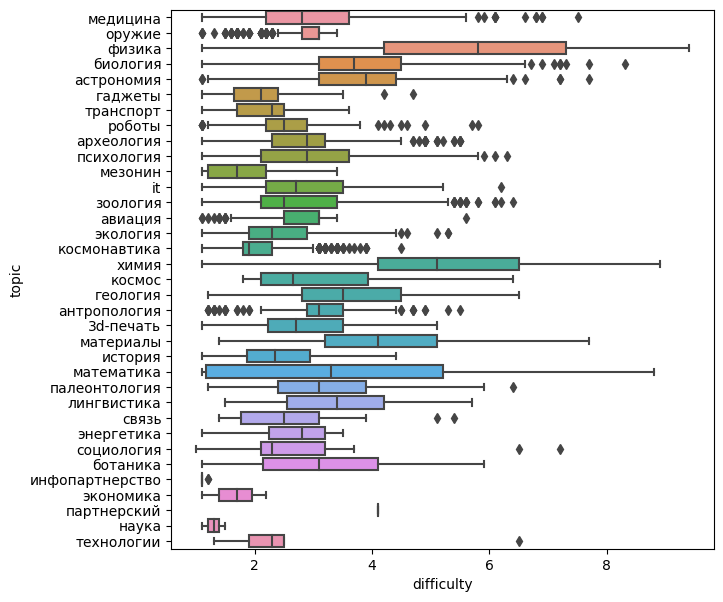

In [ ]:
sns.boxplot(data=df, x="difficulty", y="topic")
plt.show()

Are the any imbalancies with respect to year? As the bar plot shows, yes: the year 2022 appears to be less productive than the previous years. The year 2023 has even less published articles, however, it is obvious since here are only articles published before August 2023 in the dataset.

In [ ]:
days = df.copy()
days['year'] = days['date'].apply(lambda x: x.split('.')[2])
days['month'] = days['date'].apply(lambda x: x.split('.')[1])
days['day'] = days['date'].apply(lambda x: x.split('.')[0])

days = days.sort_values(by=['year', 'month', 'day'])
days.tail(5)

,time,date,difficulty,topic,heading,author,text,length_of_text,year,month,day
10102,13:37,28.08.23,2.2,медицина,ковид надорвал подростку легкое,слава гоменюк,мальчик-подросток с астмой в анамнезе обратил...,189,23,08,28
10103,11:32,28.08.23,2.1,археология,археологи нашли в вирджинии останки участников...,михаил подрезов,американские археологи проводившие раскопки в...,371,23,08,28
10104,10:32,28.08.23,3.2,археология,в палеофекалиях древних добытчиков соли нашли ...,михаил подрезов,палеопаразитологи исследовали 35 палеофекалий...,473,23,08,28
10105,09:47,28.08.23,1.5,роботы,американцы сделали человекоподобного робота ap...,андрей фокин,американская компания apptronik представила р...,498,23,08,28
10106,09:29,28.08.23,1.5,археология,роговые гребни указали на связи между хедебю и...,михаил подрезов,группа ученых из великобритании германии испа...,141,23,08,28


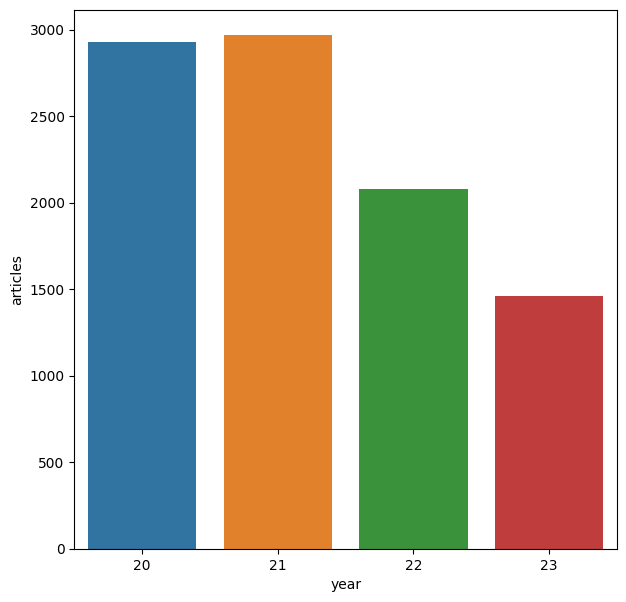

In [ ]:
sns.barplot(data=days.groupby('year', as_index=False).agg({'time':'count'}).sort_values(by='year').rename(columns={'time':'articles'}),
            x='year', y='articles')
plt.show()

By the way, which topics were the most popular every year? As seen from the stacked plot, zoology and cosmonautics steadily keep the place among the most popular topics. Medicine is one of the most common topics as well, experiencing the singificant growth in 2023. Archeology entered the group of the most popular topics only in 2021, but since then it remained popular till today. Texts about weapons, conversely, were popular in 2020-2021, but completely lost their popularity in 2022.

In [ ]:
years_topics = days.groupby(['year', 'topic'], as_index=False).agg({'text':'count'}).rename(columns={'text':'articles'})
years_sum_articles = days.groupby('year', as_index=False).agg({'text':'count'}).rename(columns={'text':'articles_total'})
years_topics = years_topics.merge(years_sum_articles, on='year', how='left')
years_topics['articles_total'] = years_topics['articles']/years_topics['articles_total']
years_topics = years_topics.rename(columns={'articles_total':'articles_percentage'})
years_topics.head(5)

,year,topic,articles,articles_percentage
0,20,3d-печать,14,0.004781
1,20,it,50,0.017077
2,20,авиация,120,0.040984
3,20,антропология,24,0.008197
4,20,археология,46,0.015710


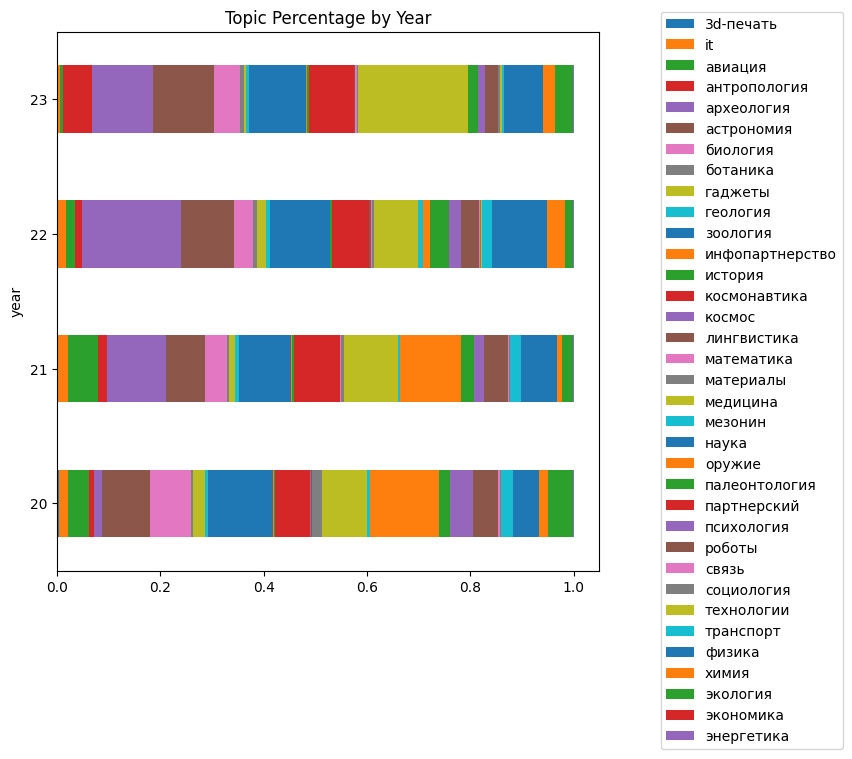

In [ ]:
pvt = years_topics[['year', 'topic', 'articles_percentage']].pivot_table(values='articles_percentage', index='year', columns='topic')
plot = pvt.reset_index().plot(x = 'year', kind = 'barh', stacked = True, title = 'Topic Percentage by Year', mark_right = True)
plot.legend(bbox_to_anchor=(1.1, 1.05))
plt.show(plot)

The same data, but in a heatmap:

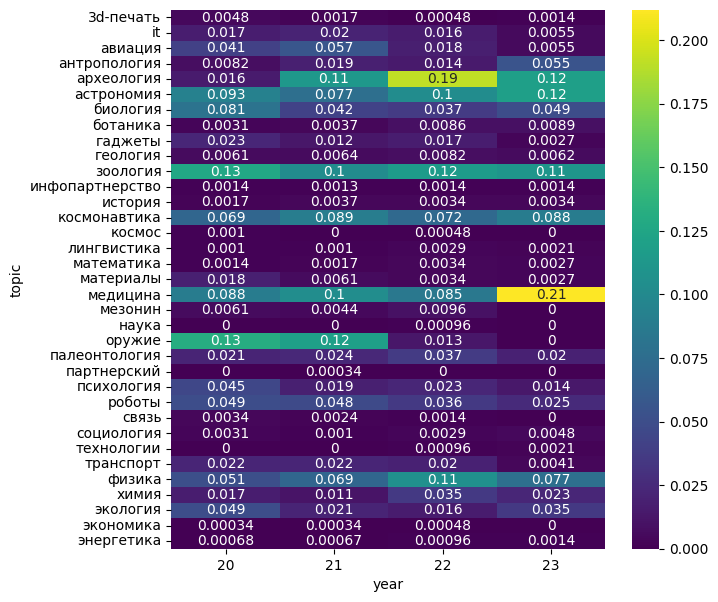

In [ ]:
pvt = pvt.fillna(0)
sns.heatmap(pvt.transpose(), annot=True, cmap="viridis")
plt.show()

The complexity of the articles, however, apparently does not vary through the years. The median difficulty remains about 3 every year.

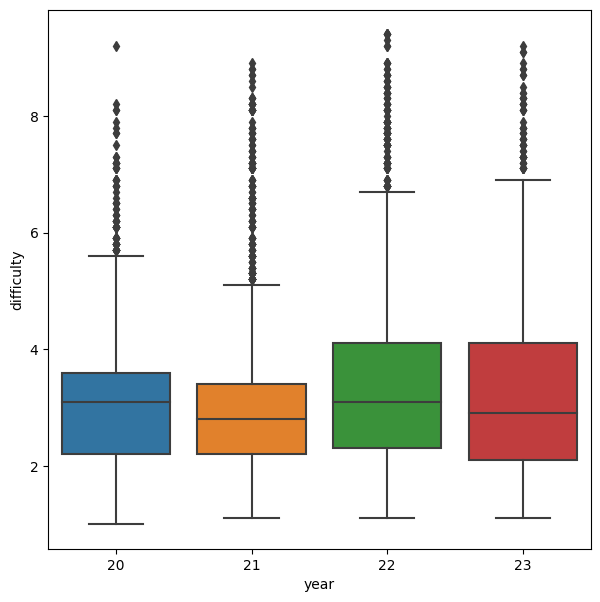

In [ ]:
sns.boxplot(data=days, x="year", y="difficulty")
plt.show()

At the dot plot, we can see the average complexity of the articles released in a certain date. As expected, most dots are grouped between 2 and 4. There are some ouliers, including the days with average complexity above 7 (maybe, those are the days when only one, but a very sophisticated, article was released). There are no visible patterns like growth or fell of average difficulty per day.

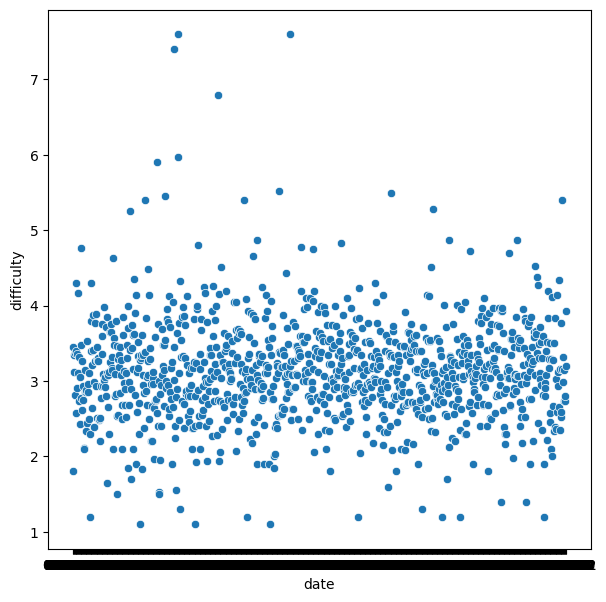

In [ ]:
avg_diff = df.groupby('date', as_index=False).agg({'difficulty':'mean'})
sns.scatterplot(data=avg_diff, x='date', y='difficulty')
plt.show()

What can influence the difficulty though? I suppose that the longer article is, the more likely is that it will be difficult. The dot plot confirms this hypothesis: there is a visible correlation between the length of the text and its difficulty.

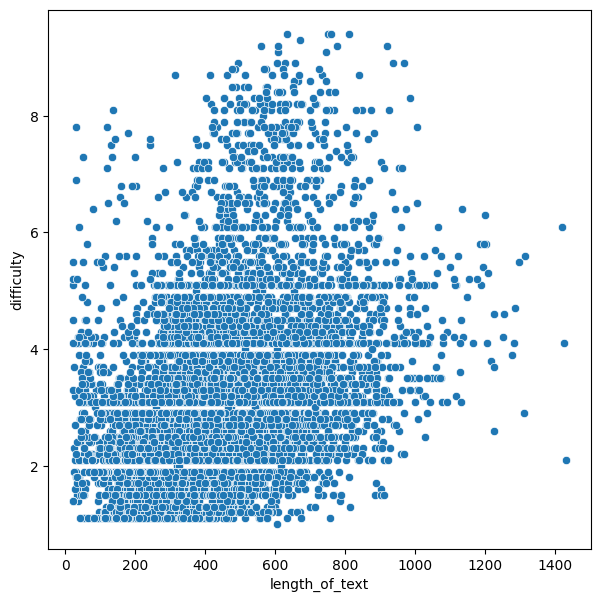

In [ ]:
sns.scatterplot(data=df, x="length_of_text", y="difficulty")
plt.show()

Which topics are the leaders in producing longreads? It seems, zoology and biology (I have no clue why).

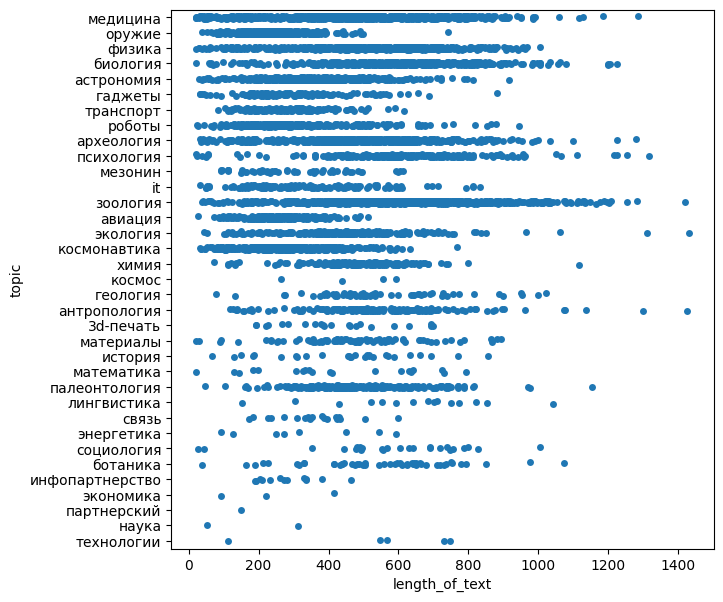

In [ ]:
sns.stripplot(data=df, x="length_of_text", y="topic")
plt.show()

# Linear models evaluation

Before training and testing the neural network, it would be useful to check if the difficulty could truly be predicted from the text data. Let us run two simple linear models: a Linear Regression for a regression task, and a Logistic Regression for a classification task.

For the classification task, we have to assign each observation its own class (a down-rounded difficulty). In total, we obtain nine classes. For clear computation, we need to substract 1 from each of the results (so there are nine classes from 0 to 8).

In [ ]:
df['class'] = round(df['difficulty']).apply(lambda x: int(x)-1)
class_names = [v for v in df['class'].unique().tolist()] #we will need it further for training

In [ ]:
sent_classes = df.groupby('class').agg({'text':'count'}).rename(columns={'text':'count'})
sent_classes

,count
class,
0,496
1,3129
2,2964
3,1654
4,584
5,273
6,156
7,147
8,36


Our datatset is fairly large, and hereby very effort-consuming for linear models. Given the lack of balance in it (see the graph below), it might be hard to make predictions for rare classes. Thus, the predictions will be made on smaller and balanced datasets.

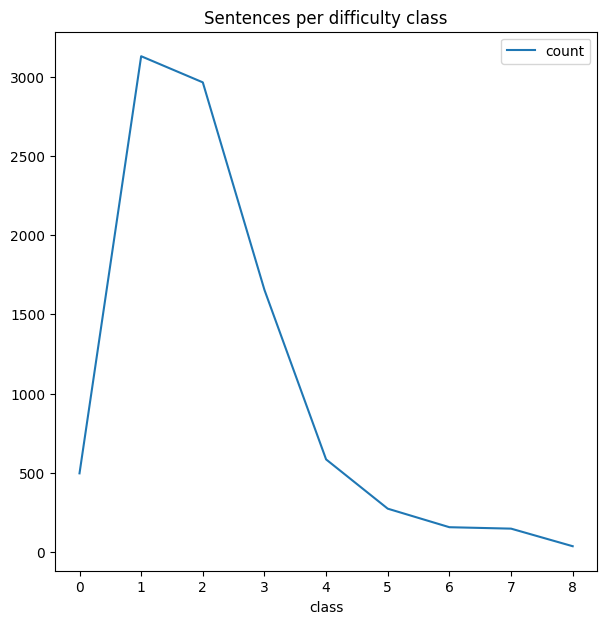

In [ ]:
sns.lineplot(sent_classes).set(title='Sentences per difficulty class')
plt.show()

In [ ]:
#the function to create a new dataset
#it reduces the number of observations for the most common classes (1, 3, and 3)
#there will be no more than 500 observations for those classes

def balance_data(df, ind, new_df):
  df_500 = df[df['class'] == ind].sample(500)
  return pd.concat([new_df, df_500])

In [ ]:
#a new dataset

df1 = df[df['class'] == 0]

for i in range(1, 5):
  df1 = balance_data(df, i, df1)

df1 = pd.concat([df1, df[df['class'] > 4]])

In [ ]:
sent_class_balanced = df1.groupby('class').agg({'text':'count'}).rename(columns={'text':'count'})
sent_class_balanced

,count
class,
0,496
1,500
2,500
3,500
4,500
5,273
6,156
7,147
8,36


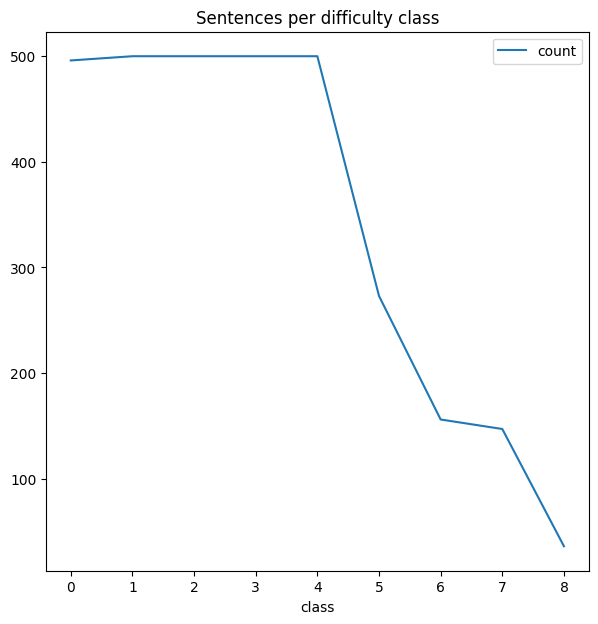

In [ ]:
#number of observations

sns.lineplot(sent_class_balanced).set(title='Sentences per difficulty class')
plt.show()

Then, vectorize the texts using Tf-Idf vectorizer.

In [ ]:
def vec_dataframe(df, stopwords, vectorizer):
  text_df = df['text']
  vec = vectorizer(stop_words=stopwords)
  df_transformed = vec.fit_transform(text_df)
  return pd.DataFrame(df_transformed.toarray(), columns = vec.get_feature_names_out())

In [ ]:
nltk.download('stopwords')

vec_df = vec_dataframe(df1, stopwords.words('russian'), TfidfVectorizer)
vec_df.head()

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


,00,000,000000000003,000001,00001,00006,00007,0001,0002,00021,...,ящиках,ящике,ящики,ящиков,ёити,ёрн,ёсино,ѿсьлицѣ,ὀδούς,ℏω
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
vec_df.shape

(3108, 117878)

After the texts are prepared for processing, we are ready to make predictions. I initialized the function which gives the metrics for regression (MAE, MSE, R2, etc) as an output.

In [ ]:
def RegressionMetrics(y_test, y_pred):
    mae = mean_absolute_error(y_test, y_pred)
    mdae = median_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    mape = mean_absolute_percentage_error(y_test, y_pred)
    r_squared = r2_score(y_test, y_pred)
    print('Mean Absolute Error: ', mae)
    print('Median Absolute Error: ', mdae)
    print('Mean Squared Error: ', mse)
    print('Mean Absolute Percentage Error: ', mape)
    print('R2 score: ', r_squared)
    sns.regplot(x=y_test, y=y_pred).set(title='Predicted/True test rates') #plot the R2 coefficient
    plt.show()

The following function is for training and predicting the result. It returns the regression metrics if we aim to predict difficulty, and the classification metrics (accuracy, F1 score, First- and Second-Type Errors) if we aim to predict class.

In [ ]:
def model_predict(model, X, y, classification):
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=100)
  model.fit(X_train, y_train)
  y_pred = model.predict(X_test)
  if classification:
    print('Training set score: {:2f}'.format(model.score(X_train, y_train)))
    print('Average test set score: {:2f}'.format(model.score(X_test, y_test)))
    print('F1-score: {:2f}'.format(f1_score(y_test, y_pred, average='weighted')))
    cm = confusion_matrix(y_test, y_pred, normalize='all')
    cm_display = ConfusionMatrixDisplay(cm).plot()
  else:
    RegressionMetrics(y_test, y_pred)

The predictions of the logistic regression:

Training set score: 0.926790
Average test set score: 0.443730
F1-score: 0.434665


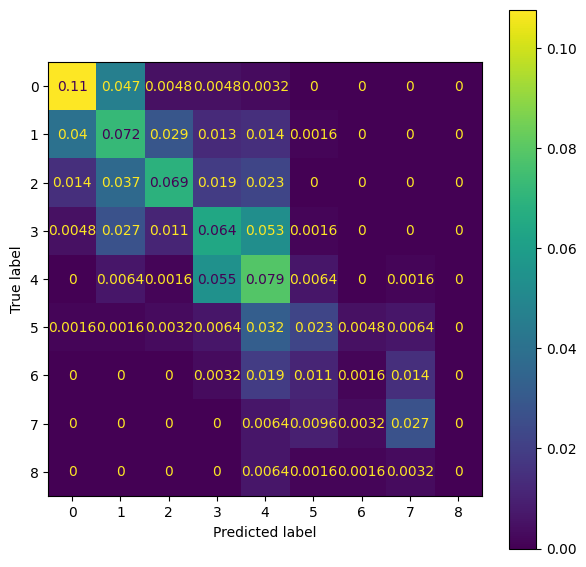

In [ ]:
model_predict(LogisticRegression(), vec_df, df1['class'], classification=True)

The predictions of the linear regression:

Mean Absolute Error:  0.7872861078764145
Median Absolute Error:  0.6239571392547916
Mean Squared Error:  1.0581950099128599
Mean Absolute Percentage Error:  0.29899189947289434
R2 score:  0.7311553506825268


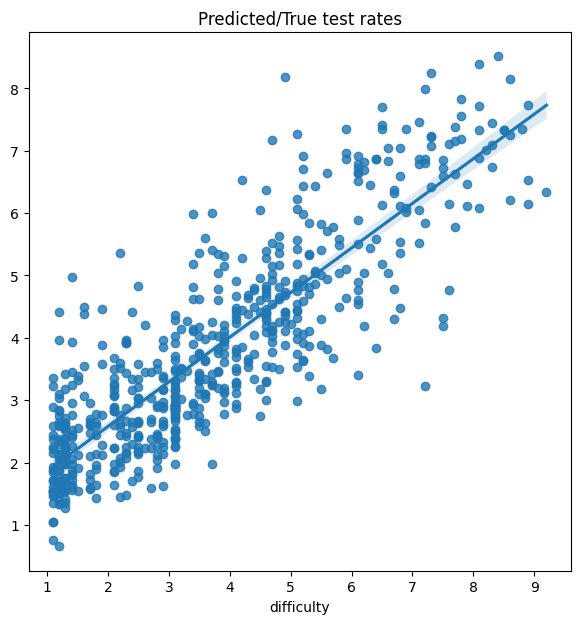

In [ ]:
model_predict(LinearRegression(), vec_df, df1['difficulty'], classification=False)

The results shown by linear regression seem to be really impressive (R2 > 0.7)

# NN models: preparation

For the task, I decided to use BERT multilingual, as soon as multilingual models, as shown in several works, tend to show better results than monolingual ones (the obvious drawback is its large size and time-consumption).

In [ ]:
PRE_TRAINED_MODEL_NAME = 'bert-base-multilingual-uncased'
#PRE_TRAINED_MODEL_NAME = 'DeepPavlov/rubert-base-cased'

tokenizer = BertTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME)

In [ ]:
RANDOM_SEED = 150
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

print(device)

cuda:0


Prepare train and test set.

In [ ]:
df_train, df_test = train_test_split(df, test_size=0.4, random_state=RANDOM_SEED)
df_val, df_test = train_test_split(df_test, test_size=0.5, random_state=RANDOM_SEED)

print('Train set size: ', df_train.shape)
print('Validation set size: ', df_val.shape)
print('Test set size: ', df_test.shape)

Train set size:  (5663, 8)
Validation set size:  (1888, 8)
Test set size:  (1888, 8)


Now let's try two tasks again (classification and regression). Unlike the plain linear models, the NN models will be run on the whole dataset, not a balanced sample.

## Classification

We need to tokenize our text inputs first and load them into a torch-tolerable dataset.

In [ ]:
def tokenize(dataframe):
    return tokenizer(dataframe['text'].to_list(), truncation=True, padding=True,
                   return_token_type_ids=False, return_attention_mask=True, max_length=256)

In [ ]:
train_encodings = tokenize(df_train)
val_encodings = tokenize(df_val)
test_encodings = tokenize(df_test)

In [ ]:
class TorchDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

In [ ]:
df_train_nn = TorchDataset(train_encodings, df_train['class'].to_list())
df_val_nn = TorchDataset(val_encodings, df_val['class'].to_list())
df_test_nn = TorchDataset(test_encodings, df_test['class'].to_list())

Then, initialize the necessary arguments for network training and create an object for classification.

In [ ]:
def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='weighted')
    acc = accuracy_score(labels, preds)
    return {
        'accuracy': acc,
        'f1': f1,
        'precision': precision,
        'recall': recall
    }

In [ ]:
training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=10,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    warmup_steps=500,
    weight_decay=0.01,
    logging_dir='./logs',
    logging_steps=10,
)

In [ ]:
class Classifier(nn.Module):

    def __init__(self, n_classes):
        super().__init__()
        self.bert = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME)
        self.drop = nn.Dropout(p=0.2)
        self.out = nn.Linear(768, n_classes)
        self.n_classes = n_classes

    def forward(self,
            input_ids=None,
            attention_mask=None,
            token_type_ids=None,
            position_ids=None,
            head_mask=None,
            inputs_embeds=None,
            labels=None,
            output_attentions=None,
            output_hidden_states=None
        ):

            last_hidden_state, pooled_output = self.bert(input_ids=input_ids,
                                                         attention_mask=attention_mask,
                                                         return_dict=False)
            output = self.drop(pooled_output)
            logits = self.out(output)
            loss = None
            if labels is not None:
                loss_fct = CrossEntropyLoss()
                loss = loss_fct(logits.view(-1, self.n_classes), labels.view(-1))
            output = (logits,)
            return ((loss,) + output) if loss is not None else output

In [ ]:
model1 = Classifier(len(class_names))
model1 = model1.to(device)

The model is ready for training!

In [ ]:
trainer = Trainer(model=model1, args=training_args, train_dataset=df_train_nn,
                  eval_dataset=df_val_nn, compute_metrics = compute_metrics)

In [ ]:
trainer.train()

Step,Training Loss
10,2.220600
20,2.196100
30,2.173800
40,2.148600
50,2.064900
60,1.931800
70,1.677200
80,1.677000
90,1.747900
100,1.590200


TrainOutput(global_step=3540, training_loss=0.6876240490604255, metrics={'train_runtime': 2873.0166, 'train_samples_per_second': 19.711, 'train_steps_per_second': 1.232, 'total_flos': 0.0, 'train_loss': 0.6876240490604255, 'epoch': 10.0})

In [ ]:
trainer.evaluate()

{'eval_loss': 2.6386373043060303,
 'eval_accuracy': 0.5444915254237288,
 'eval_f1': 0.5400802540834749,
 'eval_precision': 0.5441511620021775,
 'eval_recall': 0.5444915254237288,
 'eval_runtime': 30.026,
 'eval_samples_per_second': 62.879,
 'eval_steps_per_second': 3.93,
 'epoch': 10.0}

In [ ]:
trainer.evaluate(eval_dataset=df_test_nn, metric_key_prefix="test")

{'test_loss': 2.736125946044922,
 'test_accuracy': 0.517478813559322,
 'test_f1': 0.5137187848050234,
 'test_precision': 0.5141690937819279,
 'test_recall': 0.517478813559322,
 'test_runtime': 29.8205,
 'test_samples_per_second': 63.312,
 'test_steps_per_second': 3.957,
 'epoch': 10.0}

Not bad for a multiclass classification. Now have a look at regression.

## Regression

In a regression task, it is necessary to scale data. We use sklearn's standard scaler, which resamples the data creating the average 0 and standard deviation 1.

In [ ]:
scaler = StandardScaler()
scaler.fit(df_train.difficulty.values.reshape(-1, 1))

df_train['diff_norm'] = scaler.transform(df_train.difficulty.values.reshape(-1, 1))
df_val['diff_norm'] = scaler.transform(df_val.difficulty.values.reshape(-1, 1))
df_test['diff_norm'] = scaler.transform(df_test.difficulty.values.reshape(-1, 1))

In [ ]:
df_train.sample(10)

,time,date,difficulty,topic,heading,author,text,length_of_text,diff_norm
5478,19:23,24.09.21,5.1,физика,аномальную ионизацию атомов объяснили резонансами,марат хамадеев,физики провели численную симуляцию процесса и...,468,1.382169
5358,18:59,14.09.21,2.1,биология,американский стартап получил 15 миллионов долл...,семён морозов,биолог джордж чёрч и предприниматель бен ламм...,163,-0.756183
1032,22:21,12.05.20,3.3,психология,стрессовая реакция заставила людей меньше бесп...,елизавета ивтушок,немецкие ученые выяснили что воздействие стре...,666,0.099158
4415,13:50,08.06.21,1.8,археология,скелет человека в кандалах указал на рабство в...,елена синицкая,британские археологи исследовали костные оста...,659,-0.970018
5050,16:31,10.08.21,2.5,авиация,инженер представил концепцию гибридного конвер...,василиса чернявцева,американский инженер стивен козлофф показал к...,259,-0.471069
1646,10:06,09.07.20,4.5,астрономия,астрономы обнаружили пару нейтронных звезд с о...,кристина уласович,астрономы обнаружили систему нейтронных звезд...,404,0.954498
3200,14:50,15.01.21,2.7,зоология,электрических угрей застали за коллективной ох...,сергей коленов,электрические угри electrophorus voltai оказа...,396,-0.328512
999,18:23,07.05.20,2.4,зоология,древесные лягушки обманули хищников хоровым пе...,алиса бахарева,древесные лягушки курносые смилиски smilisca ...,509,-0.542348
5527,13:12,01.10.21,2.8,оружие,северная корея испытала зенитную ракету нового...,василиса чернявцева,северокорейская академия оборонных наук испыт...,191,-0.257234
6582,16:30,03.02.22,2.1,археология,морские археологи нашли затонувший корабль кап...,михаил подрезов,морские археологи сообщили что сумели идентиф...,398,-0.756183


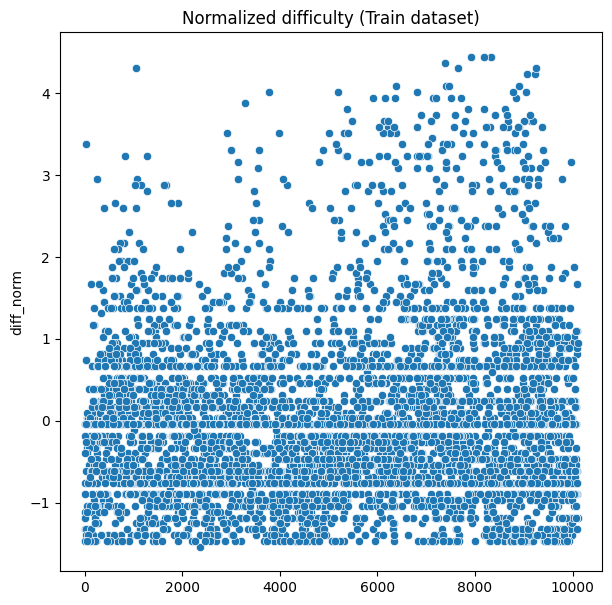

In [ ]:
sns.scatterplot(df_train['diff_norm']).set(title='Normalized difficulty (Train dataset)')
plt.show()

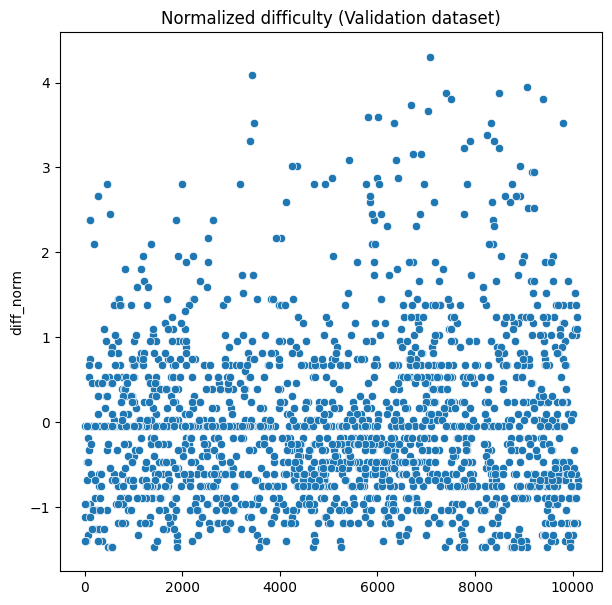

In [ ]:
sns.scatterplot(df_val['diff_norm']).set(title='Normalized difficulty (Validation dataset)')
plt.show()

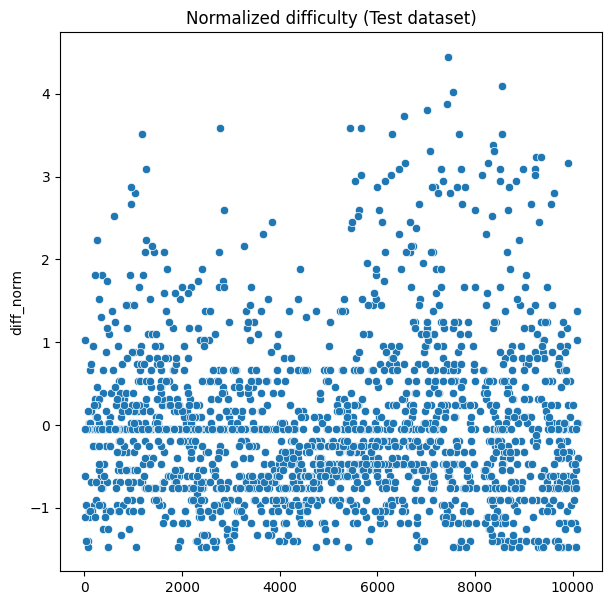

In [ ]:
sns.scatterplot(df_test['diff_norm']).set(title='Normalized difficulty (Test dataset)')
plt.show()

Create another class for data preparation.

In [ ]:
class TextToDataset(Dataset):

    def __init__(self, data, maxlen, tokenizer):
        self.df = data.reset_index()
        self.tokenizer = tokenizer
        self.maxlen = maxlen

    def __len__(self):
        return self.df.shape[0]

    def __getitem__(self, index):
        text = self.df.loc[index, 'text']
        target = self.df.loc[index, 'diff_norm']

        tokens = self.tokenizer.tokenize(text)
        tokens = ['[CLS]'] + tokens + ['[SEP]']
        if len(tokens) < self.maxlen:
            tokens = tokens + ['[PAD]' for _ in range(self.maxlen - len(tokens))]
        else:
            tokens = tokens[:self.maxlen-1] + ['[SEP]']

        input_ids = self.tokenizer.convert_tokens_to_ids(tokens)
        input_ids = torch.tensor(input_ids)
        attention_mask = (input_ids != 0).long()

        target = torch.tensor(target, dtype=torch.float32)

        return input_ids, attention_mask, target

Then, create dataloaders for our model.

In [ ]:
train_set = TextToDataset(data=df_train, maxlen=256, tokenizer=tokenizer)
val_set = TextToDataset(data=df_val, maxlen=256, tokenizer=tokenizer)
test_set = TextToDataset(data=df_test, maxlen=256, tokenizer=tokenizer)

In [ ]:
train_loader = DataLoader(dataset=train_set, batch_size=16, num_workers=1)
val_loader = DataLoader(dataset=val_set, batch_size=16, num_workers=1)
test_loader = DataLoader(dataset=test_set, batch_size=16, num_workers=1)

The class for regression. As in the case of classification, I took a pretrained model and added two layers: drop-out and output. Unlike in the case of classification, the output is a single number (the classifier had an N-dimensional vecttor as an output, where N is a number of classes, i.e. 9).

In [ ]:
class Regressor(nn.Module):

    def __init__(self, drop_rate=0.2):

        super(Regressor, self).__init__()
        self.bert = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME)
        self.regressor = nn.Sequential(
            nn.Dropout(drop_rate),
            nn.Linear(768, 1))

    def forward(self, input_ids, attention_mask):

        outputs = self.bert(input_ids, attention_mask)
        class_label_output = outputs[1]
        outputs = self.regressor(class_label_output)

        return outputs

Initialize the training loop and train our module!

In [ ]:
def train_regression(model, criterion, scheduler, optimizer, train_loader, epochs, device):

    for epoch in trange(epochs, desc="Epoch"):
        model.train()
        train_loss = 0
        for i, (input_ids, attention_mask, target) in enumerate(iterable=train_loader):
            optimizer.zero_grad()

            input_ids, attention_mask, target = input_ids.to(device), attention_mask.to(device), \
            target.to(device)

            output = torch.Tensor(model(input_ids=input_ids, attention_mask=attention_mask))

            loss = criterion(output.squeeze(), target.squeeze())
            loss.backward()
            clip_grad_norm(model.parameters(), 2)
            optimizer.step()
            scheduler.step()

            train_loss += loss.item()
            #if i%50==0:
            #  print('Target: ', target)
            #  print('Output: ', output)

        print("Epoch {} complete! Training loss is {}".format(epoch+1, train_loss/len(train_loader)))

In [ ]:
model2 = Regressor(drop_rate=0.2)
model2.to(device)

Regressor(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(105879, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine

In [ ]:
epochs = 10
steps = len(train_loader)*epochs
loss_function = nn.MSELoss()
optimizer = optim.Adam(params=model2.parameters(), lr=1e-5)
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=steps)

train_regression(model=model2,
      criterion=loss_function,
      scheduler=scheduler,
      optimizer=optimizer,
      train_loader=train_loader,
      epochs = epochs,
      device = device)

Epoch:  10%|█         | 1/10 [04:21<39:17, 261.90s/it]

Epoch 1 complete! Training loss is 0.47052365556190917


Epoch:  20%|██        | 2/10 [08:42<34:51, 261.42s/it]

Epoch 2 complete! Training loss is 0.3283264566486501


Epoch:  30%|███       | 3/10 [13:03<30:26, 260.87s/it]

Epoch 3 complete! Training loss is 0.25087177274632927


Epoch:  40%|████      | 4/10 [17:23<26:04, 260.70s/it]

Epoch 4 complete! Training loss is 0.1934716037848154


Epoch:  50%|█████     | 5/10 [21:44<21:44, 260.80s/it]

Epoch 5 complete! Training loss is 0.16701629618972036


Epoch:  60%|██████    | 6/10 [26:05<17:23, 260.91s/it]

Epoch 6 complete! Training loss is 0.1325878543742422


Epoch:  70%|███████   | 7/10 [30:26<13:02, 260.79s/it]

Epoch 7 complete! Training loss is 0.10572746868829354


Epoch:  80%|████████  | 8/10 [34:46<08:41, 260.67s/it]

Epoch 8 complete! Training loss is 0.09324081418614856


Epoch:  90%|█████████ | 9/10 [39:07<04:20, 260.74s/it]

Epoch 9 complete! Training loss is 0.08103752025471485


Epoch: 100%|██████████| 10/10 [43:28<00:00, 260.82s/it]

Epoch 10 complete! Training loss is 0.0715525593098232


Evaluation of the model:

In [ ]:
def evaluate(model, loss_function, dataloader, device):

    model.eval()
    test_loss = []

    for batch in dataloader:
        batch_inputs, batch_masks, batch_labels = \
                                 tuple(b.to(device) for b in batch)
        with torch.no_grad():
            outputs = model(batch_inputs, batch_masks)
        loss = loss_function(outputs, batch_labels)
        test_loss.append(loss.item())

    return test_loss

In [ ]:
val_loss = evaluate(model2, loss_function, val_loader, device)

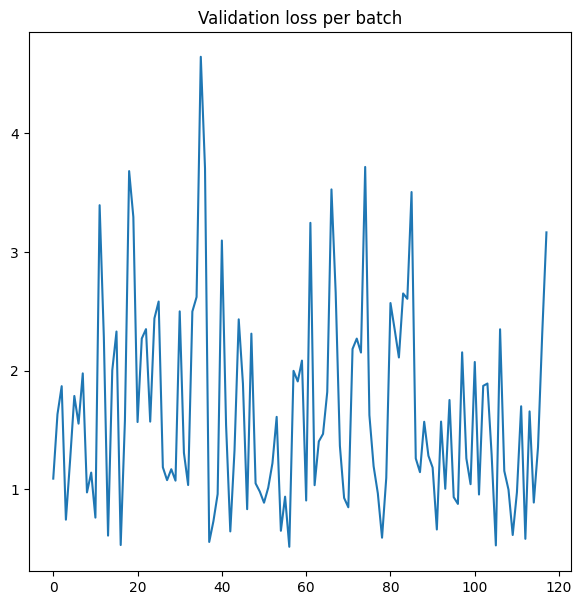

In [ ]:
sns.lineplot(np.array(val_loss)).set(title='Validation loss per batch')
plt.show()

Now we can test our module and evaluate the results

In [ ]:
def predict_regression(model, dataloader, device):

    predicted_label = []

    with torch.no_grad():
        for input_ids, attention_mask, target in (dataloader):

            input_ids, attention_mask, target = input_ids.to(device), attention_mask.to(device),\
            target.to(device)
            output = model(input_ids, attention_mask)
            predicted_label += output

    return predicted_label

In [ ]:
output = predict_regression(model2, test_loader, device)

In [ ]:
y_pred = scaler.inverse_transform(np.array([float(output[i][0]) for i in range(len(df_test))]).reshape(-1, 1))
y_test = df_test.difficulty.to_numpy()

Mean Absolute Error:  0.6175600433905871
Median Absolute Error:  0.4402782678962821
Mean Squared Error:  0.7300954460451933
Mean Absolute Percentage Error:  0.21630978614432678
R2 score:  0.5940645107331792


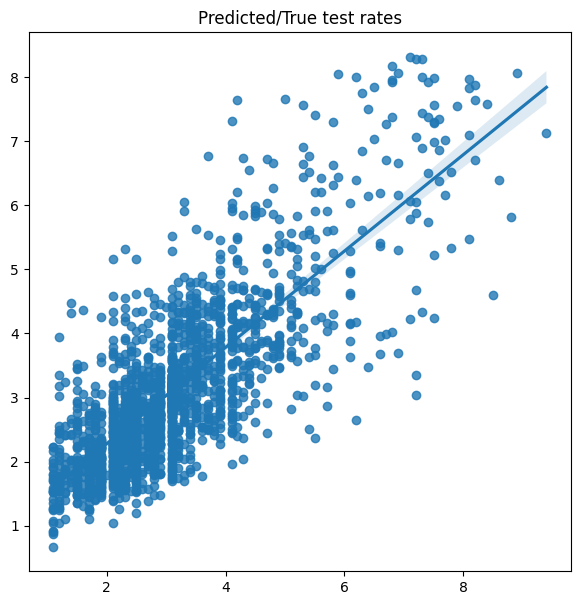

In [ ]:
mae = mean_absolute_error(y_test, y_pred)
mdae = median_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
mape = mean_absolute_percentage_error(y_test, y_pred)
r_squared = r2_score(y_test, y_pred)

print('Mean Absolute Error: ', mae)
print('Median Absolute Error: ', mdae)
print('Mean Squared Error: ', mse)
print('Mean Absolute Percentage Error: ', mape)
print('R2 score: ', r_squared)
sns.regplot(x=y_test, y=y_pred).set(title='Predicted/True test rates')
plt.show()

In [ ]:
#torch.cuda.empty_cache()

The network seems to work quite satisfactory, however, given the lack of balance in the dataset, most of the predictions group close to the lower values (when trained on the balanced and small dataset df1, the same model showed R2 about 0.73).